# Kalman Filter 

In [1]:
# include libraries
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import pandas as pd

# Needed Functions

In [2]:
def CSV_Read_Lidar_data(data_path):
    rows = []
    with open(data_path, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            rows.append(row)

    dataframe = pd.DataFrame([rows[0], rows[1], rows[2], rows[3]], ['Rho', 'Alpha', 'X', 'Y'])

    return dataframe

In [3]:
def covarience_line_fitting(points_in_line, line_alpha_rho, sigma_angle=0, sigma_dist=.005):
    sigma_angle = sigma_angle * np.ones(len(points_in_line))
    sigma_dist = sigma_dist * np.ones(len(points_in_line))

    data = np.array(points_in_line)

    #INPUIT IS X AND Y POINTS WITHIN A LINE
    dist = line_alpha_rho[1]  # whatever positions stores the distances from 0,0
    angle = line_alpha_rho[0]  # whatever positions stores the angles with the x axis
    
    x = data[:,0]
    y = data[:,1]

    n = len(x)
    x_bar = sum(x) / n
    y_bar = sum(y) / n

    S_x2 = sum((x - x_bar) ** 2)
    S_y2 = sum((y - y_bar) ** 2)
    S_xy = sum((x - x_bar) * (y - y_bar))

    # line paramters based on inputs data
    alpha = 0.5 * math.atan2(-2 * S_xy, S_y2 - S_x2)
    rho = x_bar * math.cos(alpha) + y_bar * math.sin(alpha)

    C_l = np.zeros(2)
    for i in range(0, n - 1):
        # The covariance of the measurement
        C_m = np.array([[sigma_angle[i], 0],
                        [0, sigma_dist[i]]])
        A = np.zeros((2, 2))

        # The jacobian of the line fit with respect to x and y
        A[1, 0] = ((y_bar - y[i]) * (S_y2 - S_x2) + 2 * S_xy * (x_bar - x[i])) / ((S_y2 - S_x2) ** 2 + 4 * S_xy ** 2)

        A[1, 1] = ((x_bar - x[i]) * (S_y2 - S_x2) - 2 * S_xy * (y_bar - y[i])) / ((S_y2 - S_x2) ** 2 + 4 * S_xy **2)

        A[0, 0] = math.cos(alpha) / n - x_bar * math.sin(alpha) * A[1, 0] + y_bar * math.cos(alpha) * A[1, 0]
        A[0, 1] = math.sin(alpha) / n - x_bar * math.sin(alpha) * A[1, 1] + y_bar * math.cos(alpha) * A[1, 1]

        # Jacobian of function converting dist and angle to x and y

        B = np.array([[math.cos(angle), -dist * math.sin(angle)],
                      [math.sin(angle), -dist * math.cos(angle)]])
        J = A @ B
        C_l = C_l + J * C_m * J.T

    return rho, alpha, C_l

In [4]:
# Bunch of algorithms for split and merge

def GetPolar(X, Y):
    # center the data
    X = X - np.mean(X)
    Y = Y - np.mean(Y)
    # fit line through the first and last point (X and Y contains 2 points, start and end of the line)
    k, n = np.polyfit(X, Y, 1)
    alpha = math.atan(-1 / k)  # in radians
    ro = n / (math.sin(alpha) - k * math.cos(alpha))
    return ro, alpha

def Cartesian2Polar(x, y):
    r = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return r, phi

def CheckPolar(ro, alpha):
    if ro < 0:
        alpha = alpha + math.pi
        if alpha > math.pi:
            alpha = alpha - 2 * math.pi
        ro = -ro
    return ro, alpha

def getDistance(P, Ps, Pe):  # point to line distance, where the line is given with points Ps and Pe
    if np.all(np.equal(Ps, Pe)):
        return np.linalg.norm(P - Ps)
    return np.divide(np.abs(np.linalg.norm(np.cross(Pe - Ps, Ps - P))), np.linalg.norm(Pe - Ps))

def GetMostDistant(P):
    dmax = 0
    index = -1
    for i in range(1, P.shape[0]):
        d = getDistance(P[i, :], P[0, :], P[-1, :])
        if (d > dmax):
            index = i
            dmax = d
    return dmax, index

def points_within_radius(mainpoint, points, r):
    result = []
    for point in points:
        if math.dist(mainpoint, point) <= r:
            result.append(point)
    return result

def gap_detection(lines, points, threshold):
    good_lines = []
    points_in_thresh_total = []
    for i in range(len(lines)):
        # get point 1 and point 2 of the line
        point_1 = lines[i][0]
        point_2 = lines[i][1]

        # get the distance of the line, then take a certain percentage of it (remember its based off both sides)
        line_dist = math.dist(point_2, point_1)
        r = line_dist / 2 * 0.10
        # print(r)

        # check all the points to see if they fall in theshold, store if they do
        points_in_thresh = []

        for j in range(len(points)):
            # distance = point_to_line_distance(points[j], lines[i])
            distance = getDistance(points[j], lines[i][0], lines[i][1])
            if distance <= (threshold * 1):
                # if distance < r:
                points_in_thresh.append(points[j])
        
        if len(points_in_thresh) <= 5 and line_dist <= 0.3:
            good_lines.append(lines[i])
            points_in_thresh_total.append(points_in_thresh)
            continue

        # check to see what % of points are between the threshold of the first and last point (might need my own threshold)
        p1_points = points_within_radius(point_1, points_in_thresh, r)
        p2_points = points_within_radius(point_2, points_in_thresh, r)
        # print(len(p1_points))
        # print(len(p2_points))
        # print(len(points_in_thresh))

        percent_in_radius = (len(p1_points) + len(p2_points)) / (len(points_in_thresh))
        # print(percent_in_radius)

        if percent_in_radius <= 0.40:
            # print("good line")
            good_lines.append(lines[i])
            points_in_thresh_total.append(points_in_thresh)
        # else:
        #     print("bad line")
        # plt.show()
        # print("\n")
        
    return good_lines, points_in_thresh_total

def SplitAndMerge(P, threshold):
    d, ind = GetMostDistant(P)
    if d > threshold:
        P1 = SplitAndMerge(P[:ind + 1, :], threshold)  # split and merge left array
        P2 = SplitAndMerge(P[ind:, :], threshold)  # split and merge right array
        # there are 2 "d" points, so exlude 1 (for example from 1st array)
        points = np.vstack((P1[:-1, :], P2))
    else:
        points = np.vstack((P[0, :], P[-1, :]))
    return points

def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

'~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

def Algorithm_split_and_merge(inputdataframe, threshold=0.3, plot=False):

    P = np.array([list(inputdataframe['X']), list(inputdataframe['Y'])]).T

    points = SplitAndMerge(P, threshold)

    lines = []
    for i in range(len(points) - 1):
        lines.append([points[i], points[i + 1]])
        # plt.plot([points[i][0], points[i+1][0]], [points[i][1], points[i+1][1]], '-o')
    # final_lines = lines
    final_lines, points_in_line = gap_detection(lines, P, threshold)

    # flatten it to get the shitty points
    flat_list = flatten(final_lines)
    flat_list.append(flat_list[0])
    flat_list = np.array(flat_list)

    #convert from xy back to alpha rho
    alpha_rho = []
    for i in range(len(final_lines)):
        alpha, rho = GetPolar([final_lines[i][0][0], final_lines[i][1][0]], [final_lines[i][0][1], final_lines[i][1][1]])
        alpha_rho.append([alpha, rho])

    if plot==True:
        plt.figure()
        plt.title('og')
        plt.scatter(P[:, 0], P[:, 1], c='black')
        plt.plot(points[:, 0], points[:, 1])

        plt.figure()
        plt.title('with gap detection')
        plt.scatter(P[:, 0], P[:, 1], c='black')
        plt.plot(flat_list[:, 0], flat_list[:, 1], '-o')

        plt.figure()
        plt.title('actual Lines')
        plt.scatter(P[:, 0], P[:, 1], c='black')
        for i in range(len(final_lines)):
            tmp = np.array(final_lines[i])
            plt.plot(tmp[:, 0], tmp[:, 1], '-o')
        # print(len(lines))
        # print(len(final_lines))
        plt.scatter(0, 0, c='red')  # replace this with the origin point
        plt.show()

    return final_lines, points_in_line, alpha_rho

In [5]:
def matching(z_hat_t,z_t,R_t,H_j,P_hat_t,g):

    matches = []
    v_t_matches = []
    sigmas_matches = []
    H_matches = []
    #initializedng vt

    v_t = np.zeros((2,1,len(z_t),len(z_hat_t)))
    sigma_itt = np.zeros((2,2,len(z_t),len(z_hat_t)))
    #This could be vectorized or whatever but i think itll be okay
    for i in range(len(z_t)):
        for j in range(len(z_hat_t)):
            v_t[:,:,i,j] = z_t[:,:,i] - z_hat_t[:,:,j]
            
            sigma_itt[:,:,i,j] = H_j[:,:,j] @ P_hat_t @ H_j[:,:,j].T + R_t[i]
    # Mahalanobis distance
    for i in range(len(z_t)):
        for j in range(len(z_hat_t)):
            v_ = v_t[:,:,i,j]
            sigma_ = sigma_itt[:,:,i,j]
            # print(v_)
            # print(v_.T)
            mah_dist = v_.T @ sigma_ @ v_
            # print(mah_dist)
            if mah_dist <= g**2:
                matches.append([i,j])
                v_t_matches.append(v_t[:,:,i,j])
                sigmas_matches.append(sigma_itt[:,:,i,j])
                H_matches.append(H_j[:,:,j])
                
    return matches, v_t_matches, sigmas_matches,H_matches

In [6]:
def pos_estimation(H_t, x_hat, v_t,P_t_hat,sigmas):
    # print(H_t)
    # print(v_t)
    # print(sigmas)
    

    for i in range(len(H_t)):
        K_t = P_t_hat @ H_t[i].T @ np.linalg.pinv(sigmas[i])
        print(f'H_t = {H_t}')
        P_t = P_t_hat - K_t @ sigmas[i] @ K_t.T

        inovation_polar = K_t @ v_t[i]
        inovation_cart = inovation_polar#Cartesian2Polar(inovation_polar[:,0], inovation_polar[1])
        x_t = x_hat + inovation_cart
        x_hat = x_t
        print(K_t)
        print('vt',v_t[i])
        print('xhat',x_hat)

    if len(H_t) == 0:
        x_t = x_hat
        P_t = P_t_hat
        return x_t, P_t

    
    return x_t, P_t

In [7]:
def measurement_prediction(x_hat, gt_map_df):
    """
    The measurements needs to take the MAP data and move the lines into the Robts frame (from world) THEN match lines together or something
    x_hat = 
    map = gt map
    data = observed map data
    """
    N = int(gt_map_df.shape[1])
    z_hat_t = np.zeros([2, 1, N]) # The pridiction of what the Lines detected should be, from map
    alpha_map = gt_map_df.loc['Alpha'].astype(float)
    rho_map = gt_map_df.loc['rhos'].astype(float)

    z_hat_t[0,0,:] = alpha_map[:] - x_hat[2] # removing the robots orientation in the world to rotate the line angles into frame
    z_hat_t[1,0,:] = rho_map[:]-x_hat[0]*np.cos(alpha_map[:])+x_hat[1]*np.sin(alpha_map[:]) # translation portion for the lines

    H_j = np.zeros([2,3,N])

    for k in range(N):
        H_j[:,:,k] = np.array([[0,  0,  -1],  
                    [-np.cos(alpha_map[k]), -np.sin(alpha_map[k]), 0]])  #it might not be able to handle this notation. Could easily be a loop

    return z_hat_t,H_j

In [8]:
# TODO pos_t_minus1 needs to be updated to previous x_hat_t after initial time step -Rob

In [9]:
def position_prediction(pos_t_minus1, delta_sl, delta_sr, b,P_t_minus1):

    delta_sl
    delta_sr

    theta_t_minus1 = pos_t_minus1[2]
  
    x_hat = np.empty((3,1))

    

    # This is previous postion + estimate of future position
    x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
                                    [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
                                    [(delta_sr-delta_sl) / b]]))
    
    delta_s = (delta_sr+delta_sl)/2
    delta_theta = (delta_sr-delta_sl) / b

    k_r =  .001
    k_l =  .001

    Q_t  = np.array([[k_r * abs(delta_sr), 0],
                    [0, k_l * abs(delta_sl) ]])
    F_deltarl = np.array([  [.5*math.cos(theta_t_minus1+delta_theta/2)-delta_s/2/b*math.sin(theta_t_minus1+delta_theta/2),.5*math.cos(theta_t_minus1+delta_theta/2)+delta_s/2/b*math.sin(theta_t_minus1+delta_theta/2)],
                            [.5*math.sin(theta_t_minus1+delta_theta/2)-delta_s/2/b*math.cos(theta_t_minus1+delta_theta/2),.5*math.sin(theta_t_minus1+delta_theta/2)+delta_s/2/b*math.cos(theta_t_minus1+delta_theta/2)],
                            [1/b,-1/b]])

    F_k_minus_1 = np.array([[1, 0, -delta_s*math.sin(theta_t_minus1+delta_theta/2)],
                            [0, 1,  delta_s*math.cos(theta_t_minus1+delta_theta/2)],
                            [0, 0, 1]])
    
    #TODO PUT IN THE FU MATRICXZ
    # @ is matrix multiplication
    P_t_minus1_2 = P_t_minus1 * np.identity(3)
    P_hat_t = F_k_minus_1 @ P_t_minus1_2 @ F_k_minus_1.T + F_deltarl@ Q_t @ F_deltarl.T
    # pos_t_minus1 = x_hat
    return x_hat, P_hat_t

# Initializing map


Ground Truth Map Generation

In [10]:
file_path = 'Data_Readers_Writers/Data/'
file_name = 'DownstairsScan_not_move_GT_LineData'

data_path = file_path + file_name + '.csv'

ground_truth_df = pd.read_csv(data_path)
ground_truth_df = ground_truth_df.T

# 1. Robot Position Prediction

In [11]:
'''
robot pos prediction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
'''
# Some values that are global

# Parameters for the robot 
# TODO this will be pulled from ros later
x_vel = 0.0
y_vel = 0.0
z_vel = 0.0



b = .235 # distance between robots wheels (meters)
wheel_radius = 0.072 # radius of the actual wheel (meters)

"""
These are the uncertainties in the are error constants representing the 
nondeterministic parameters of the motor drive and the wheel-floor interaction. Probably can be found in DOC or just tune for it
"""

# Pull these from ros, page 337, displacewmnt of left and right wheel
# ut = [delta_sl, delta_sr].T
#TODO these are placeholder values
delta_sl = 0.0
delta_sr = 0.0

# pos_t_minus1 is the [x_t-1, y_t-1, theta_t-1] position of the robot x_t-1
# the robot drives forward with the control input ut (above) to a position vector xt
# Both are world frames
#TODO get a value for this
pos_t_minus1 = np.array([[0],
                        [0],
                        [0]])
# initialize covarience matrix TODO intiialize this beter
# P_t_minus1 = 0.1
P_t_minus1 = np.array([[.5, 0, 0],
                    [0, .5, 0],
                    [0, 0, .2]])

# 2. Observation

In [12]:
# Load datapath and put into dataframe
# path to csv data
data_path = 'Data_Readers_Writers/Data/DownstairsScan_not_move_scan_data_organized.csv'
tmp_df = pd.read_csv(data_path)

#read and turn to list
lowrange = 0
highrange = 1070

scan_df = []
for i in range(int(tmp_df.shape[0]/1070)):
    lowrange = 0 + 1070 * i
    highrange = lowrange + 1070
    scan_df.append(tmp_df.iloc[lowrange:highrange, :])

# Delete any column that has an inf in the rho spot
for i in range(len(scan_df)):
    inf_cols = scan_df[i]['Rho'][np.isfinite(scan_df[i]['Rho'])]
    # print(inf_cols.index)
    scan_df[i] = scan_df[i].T[inf_cols.index].T.reset_index(drop=True)
scan_df[0]

,Rho,Alpha,X,Y
0,1.404012,0.004136,1.403976,0.008153
1,1.404048,0.008272,1.403905,0.016306
2,1.406108,0.012390,1.405787,0.024493
3,1.406192,0.016519,1.405621,0.032656
4,1.404300,0.020677,1.403408,0.040759
...,...,...,...,...
829,6.347022,1.348068,1.395949,-0.130121
830,6.352685,1.348270,1.396681,-0.122012
831,6.358349,1.348472,1.397366,-0.113900
832,6.364455,1.348367,1.399998,-0.105934


In [13]:
all_xt = []
all_xhat = []
for robot_scans in range(len(scan_df)):

    print(f'pos_t_minus1 = {pos_t_minus1}')
    x_hat, P_hat_t = position_prediction(pos_t_minus1, delta_sl, delta_sr, b, P_t_minus1)
    print(f'x_hat = {x_hat}')
    
    print(f'p_hat_t = {P_hat_t}')


    '''
    OBSERVATION ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''

    # Run the split and merge and get covar
    # apply the split and merge algorithm


    Lines, points_in_line, line_alpha_rho = Algorithm_split_and_merge(scan_df[robot_scans].astype(float),threshold=0.1, plot=False)

    # Do covarience line fitting, save data to lists
    alphas = []
    rhos = []
    covars = []
    for i in range(len(points_in_line)):
        rho, alpha, C_l = covarience_line_fitting(points_in_line[i], line_alpha_rho[i])
        # line_info.append([alpha, rho, C_l])
        alphas.append(alpha)
        rhos.append(rho)
        covars.append(C_l)

    # Create a dataframe with the good info
    all_scan_df = pd.DataFrame([alphas, rhos, covars, Lines, points_in_line], ['Alpha','rhos' ,'Covariance', 'Lines (endpoints)', ' Points within line'])



    # alpha and rho from the lidar data
    z_t = np.array([[all_scan_df.loc['Alpha'].astype(float)],
                [all_scan_df.loc['rhos'].astype(float)]])

    # Covariane matrix for eachlinec calculated
    R_t = np.array(all_scan_df.loc['Covariance'])

    # print(z_t.shape)
    # print(z_t)
    # print(R_t.shape)




    '''
    MEASUREMENT PREDICTION ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''
    z_hat_t, H_j = measurement_prediction(x_hat, ground_truth_df)


    '''
    MATCHING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''
    #TODO what is g
    g = 4 # mess with this a bit

    matches, v_t_matches, sigmas_matches, H_j = matching(z_hat_t, z_t, R_t, H_j, P_hat_t, g)


    '''
    ESTIMATION ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    '''
    x_t, P_t = pos_estimation(H_j, x_hat, v_t_matches, P_hat_t, sigmas_matches)

    P_t_minus1 = P_t
    pos_t_minus1 = x_t
    print(f'pos_t_minus1 = {pos_t_minus1}')

    all_xt.append(x_t)
    all_xhat.append(x_hat)

    print(f'Scan {robot_scans}')
    print(f'x_t = {x_t}')
    print(f'x_hat = {x_hat}')
    print(f'covarience = {P_t}')

    print('\n')
    print('\n')

pos_t_minus1 = [[0]
 [0]
 [0]]
x_hat = [[0.]
 [0.]
 [0.]]
p_hat_t = [[0.5 0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  0.2]]


/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.99912387]
 [ 0.          0.04185078]
 [-1.          0.        ]]
vt [[0.00086703]
 [0.00114622]]
xhat [[-1.14521839e-03]
 [ 4.79703093e-05]
 [-8.67027522e-04]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.04116353]
 [ 0.         -0.99915242]
 [-1.          0.        ]]
vt [[-1.57061714]
 [-5.08538119]]
xhat [[0.20818704]
 [5.08111891]
 [1.56975011]]
pos_t_minus1 = [[0.20818704]
 [5.08111891]
 [1.56975011]]
Scan 0
x_t = [[0.20818704]
 [5.08111891]
 [1.56975011]]
x_hat = [[0.]
 [0.]
 [0.]]
covarience = [[ 0.49915278 -0.02056432  0.        ]
 [-0.02056432  0.00084722  0.        ]
 [ 0.          0.    

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -1.00087392e+00]
 [ 0.00000000e+00  7.11582688e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[1.57116409]
 [0.42067055]]
xhat [[-0.21285115]
 [ 5.08114884]
 [ 1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.       

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667343]
 [  0.          -0.50042415]
 [  0.           0.        ]]
vt [[-8.81711209e-04]
 [-1.03962002e+01]]
xhat [[253.92124854]
 [ 15.77481192]
 [  1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -2.79388497]
 [ 0.         -0.11510374]
 [ 0.          0.        ]]
vt [[ 1.44059374]
 [-4.80134417]]
xhat [[267.33565188]
 [ 16.32746458]
 [  1.56975011]]
pos_t_minus1 = [[267.33565188]
 [ 16.32746458]
 [  1.56975011]]
Scan 2
x_t = [[267.33565188]
 [ 16.32746458]
 [  1.56975011]]
x_hat = [[127.64199977]
 [ 10.57230229]
 [  1.56975011]]
covarience = [[ 0.40608774 -0.00217411  0.        ]
 [-0.

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667342]
 [  0.          -0.50042415]
 [  0.           0.        ]]
vt [[-7.40807863e-04]
 [-1.03965230e+01]]
xhat [[393.61882207]
 [ 21.53013574]
 [  1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -2.5242143 ]
 [ 0.         -0.10399372]
 [ 0.          0.        ]]
vt [[ 1.44776358]
 [-4.82266385]]
xhat [[405.7922591 ]
 [ 22.03166251]
 [  1.56975011]]
pos_t_minus1 = [[405.7922591 ]
 [ 22.03166251]
 [  1.56975011]]
Scan 3
x_t = [[405.7922591 ]
 [ 22.03166251]
 [  1.56975011]]
x_hat = [[267.33565188]
 [ 16.32746458]
 [  1.56975011]]
covarience = [[ 0.36389296 -0.00173836  0.        ]
 [-0.

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667335]
 [  0.          -0.50042414]
 [  0.           0.        ]]
vt [[-2.06342625e-03]
 [-1.03957102e+01]]
xhat [[532.06555505]
 [ 27.23392686]
 [  1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.56550832]
 [ 0.         -0.02329807]
 [ 0.          0.        ]]
vt [[ 1.40604724]
 [-4.66224831]]
xhat [[534.70209523]
 [ 27.34254823]
 [  1.56975011]]
pos_t_minus1 = [[534.70209523]
 [ 27.34254823]
 [  1.56975011]]
Scan 4
x_t = [[534.70209523]
 [ 27.34254823]
 [  1.56975011]]
x_hat = [[405.7922591 ]
 [ 22.03166251]
 [  1.56975011]]
covarience = [[ 3.55422141e-01 -3.48984537e-04  0.0000000

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667341]
 [  0.          -0.50042414]
 [  0.           0.        ]]
vt [[-4.94374117e-04]
 [-1.03961817e+01]]
xhat [[660.98111915]
 [ 32.54504856]
 [  1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.59300578]
 [ 0.         -0.02443092]
 [ 0.          0.        ]]
vt [[ 1.05245167]
 [-3.92260389]]
xhat [[663.30724592]
 [ 32.64088139]
 [  1.56975011]]
pos_t_minus1 = [[663.30724592]
 [ 32.64088139]
 [  1.56975011]]
Scan 5
x_t = [[663.30724592]
 [ 32.64088139]
 [  1.56975011]]
x_hat = [[534.70209523]
 [ 27.34254823]
 [  1.56975011]]
covarience = [[ 0.34674621 -0.00035743  0.        ]
 [-0.

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667343]
 [  0.          -0.50042414]
 [  0.           0.        ]]
vt [[-2.68655728e-04]
 [-1.03965887e+01]]
xhat [[789.59121312]
 [ 37.84358537]
 [  1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.99190021]
 [ 0.         -0.04086475]
 [ 0.          0.        ]]
vt [[ -1.47558335]
 [-17.84927183]]
xhat [[807.29590964]
 [ 38.57299146]
 [  1.56975011]]
pos_t_minus1 = [[807.29590964]
 [ 38.57299146]
 [  1.56975011]]
Scan 6
x_t = [[807.29590964]
 [ 38.57299146]
 [  1.56975011]]
x_hat = [[663.30724592]
 [ 32.64088139]
 [  1.56975011]]
covarience = [[ 0.33258852 -0.00058327  0.        ]
 [-

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.1466734 ]
 [  0.          -0.50042414]
 [  0.           0.        ]]
vt [[-9.37712205e-04]
 [-1.03960871e+01]]
xhat [[933.57378408]
 [ 43.77544443]
 [  1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -2.14380318]
 [ 0.         -0.08832137]
 [ 0.          0.        ]]
vt [[ 1.47957795]
 [-4.938743  ]]
xhat [[944.16147702]
 [ 44.21164099]
 [  1.56975011]]
pos_t_minus1 = [[944.16147702]
 [ 44.21164099]
 [  1.56975011]]
Scan 7
x_t = [[944.16147702]
 [ 44.21164099]
 [  1.56975011]]
x_hat = [[807.29590964]
 [ 38.57299146]
 [  1.56975011]]
covarience = [[ 0.30323875 -0.00120917  0.        ]
 [-0.

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667333]
 [  0.          -0.50042414]
 [  0.           0.        ]]
vt [[-2.25688028e-03]
 [-1.03956179e+01]]
xhat [[1070.43365213]
 [  49.41385915]
 [   1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -1.1582728 ]
 [ 0.         -0.04771905]
 [ 0.          0.        ]]
vt [[ -1.50015152]
 [-17.95764678]]
xhat [[1091.23350591]
 [  50.27078093]
 [   1.56975011]]
pos_t_minus1 = [[1091.23350591]
 [  50.27078093]
 [   1.56975011]]
Scan 8
x_t = [[1091.23350591]
 [  50.27078093]
 [   1.56975011]]
x_hat = [[944.16147702]
 [ 44.21164099]
 [  1.56975011]]
covarience = [[ 0.28878075 -0.00059565  0. 

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667332]
 [  0.          -0.50042414]
 [  0.           0.        ]]
vt [[-1.62835861e-03]
 [-1.03955735e+01]]
xhat [[1217.50514073]
 [  55.47297682]
 [   1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.47124361]
 [ 0.         -0.01941451]
 [ 0.          0.        ]]
vt [[ 1.06775968]
 [-3.92838879]]
xhat [[1219.35636885]
 [  55.54924455]
 [   1.56975011]]
pos_t_minus1 = [[1219.35636885]
 [  55.54924455]
 [   1.56975011]]
Scan 9
x_t = [[1219.35636885]
 [  55.54924455]
 [   1.56975011]]
x_hat = [[1091.23350591]
 [  50.27078093]
 [   1.56975011]]
covarience = [[ 2.83178963e-01 -2.30784825

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667332]
 [  0.          -0.50042414]
 [  0.           0.        ]]
vt [[-8.98401319e-04]
 [-1.03945504e+01]]
xhat [[1345.61557683]
 [  60.75092848]
 [   1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -1.90816261]
 [ 0.         -0.07861335]
 [ 0.          0.        ]]
vt [[ 1.49243334]
 [-4.9925129 ]]
xhat [[1355.14210328]
 [  61.14340662]
 [   1.56975011]]
pos_t_minus1 = [[1355.14210328]
 [  61.14340662]
 [   1.56975011]]
Scan 10
x_t = [[1355.14210328]
 [  61.14340662]
 [   1.56975011]]
x_hat = [[1219.35636885]
 [  55.54924455]
 [   1.56975011]]
covarience = [[ 0.26093619 -0.00091637  0

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667326]
 [  0.          -0.50042414]
 [  0.           0.        ]]
vt [[-2.12785333e-03]
 [-1.03951488e+01]]
xhat [[1481.40857878]
 [  66.34538995]
 [   1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.92007782]
 [ 0.         -0.03790578]
 [ 0.          0.        ]]
vt [[ 1.59948197]
 [-5.42019904]]
xhat [[1486.3955837 ]
 [  66.55084683]
 [   1.56975011]]
pos_t_minus1 = [[1486.3955837 ]
 [  66.55084683]
 [   1.56975011]]
Scan 11
x_t = [[1486.3955837 ]
 [  66.55084683]
 [   1.56975011]]
x_hat = [[1355.14210328]
 [  61.14340662]
 [   1.56975011]]
covarience = [[ 0.25105358 -0.00040715  0

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667328]
 [  0.          -0.50042414]
 [  0.           0.        ]]
vt [[-4.61651211e-04]
 [-1.03950510e+01]]
xhat [[1.61266087e+03]
 [7.17527812e+01]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -1.47407732]
 [ 0.         -0.0607297 ]
 [ 0.          0.        ]]
vt [[ 1.49744498]
 [-5.00147826]]
xhat [[1.62003344e+03]
 [7.20565195e+01]
 [1.56975011e+00]]
pos_t_minus1 = [[1.62003344e+03]
 [7.20565195e+01]
 [1.56975011e+00]]
Scan 12
x_t = [[1.62003344e+03]
 [7.20565195e+01]
 [1.56975011e+00]]
x_hat = [[1486.3955837 ]
 [  66.55084683]
 [   1.56975011]]
covarience = [[ 0.23582009 -0

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.1466732 ]
 [  0.          -0.50042413]
 [  0.           0.        ]]
vt [[-1.89042048e-03]
 [-1.03958341e+01]]
xhat [[1.74630824e+03]
 [7.72588458e+01]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -1.66309038]
 [ 0.         -0.06851675]
 [ 0.          0.        ]]
vt [[ 1.42202572]
 [-4.70708107]]
xhat [[1.75413654e+03]
 [7.75813597e+01]
 [1.56975011e+00]]
pos_t_minus1 = [[1.75413654e+03]
 [7.75813597e+01]
 [1.56975011e+00]]
Scan 13
x_t = [[1.75413654e+03]
 [7.75813597e+01]
 [1.56975011e+00]]
x_hat = [[1.62003344e+03]
 [7.20565195e+01]
 [1.56975011e+00]]
covarience = [[ 0.21967616

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667313]
 [  0.          -0.50042413]
 [  0.           0.        ]]
vt [[-2.75726016e-03]
 [-1.03952998e+01]]
xhat [[1.88040485e+03]
 [8.27834185e+01]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.31262169]
 [ 0.         -0.01287953]
 [ 0.          0.        ]]
vt [[ 1.37036634]
 [-4.53424946]]
xhat [[1.88182235e+03]
 [8.28418175e+01]
 [1.56975011e+00]]
pos_t_minus1 = [[1.88182235e+03]
 [8.28418175e+01]
 [1.56975011e+00]]
Scan 14
x_t = [[1.88182235e+03]
 [8.28418175e+01]
 [1.56975011e+00]]
x_hat = [[1.75413654e+03]
 [7.75813597e+01]
 [1.56975011e+00]]
covarience = [[ 2.16849234

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667318]
 [  0.          -0.50042413]
 [  0.           0.        ]]
vt [[-2.21237587e-03]
 [-1.03947868e+01]]
xhat [[2.00808443e+03]
 [8.80436197e+01]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.29584701]
 [ 0.         -0.01218844]
 [ 0.          0.        ]]
vt [[ 1.39191841]
 [-4.60097623]]
xhat [[2.00944562e+03]
 [8.80996984e+01]
 [1.56975011e+00]]
pos_t_minus1 = [[2.00944562e+03]
 [8.80996984e+01]
 [1.56975011e+00]]
Scan 15
x_t = [[2.00944562e+03]
 [8.80996984e+01]
 [1.56975011e+00]]
x_hat = [[1.88182235e+03]
 [8.28418175e+01]
 [1.56975011e+00]]
covarience = [[ 2.14208421

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667275]
 [  0.          -0.50042411]
 [  0.           0.        ]]
vt [[-5.07153534e-03]
 [-1.03943634e+01]]
xhat [[2.13570255e+03]
 [9.33012885e+01]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.36900401]
 [ 0.         -0.01520239]
 [ 0.          0.        ]]
vt [[ 1.3333304 ]
 [-4.42922665]]
xhat [[2.13733695e+03]
 [9.33686233e+01]
 [1.56975011e+00]]
pos_t_minus1 = [[2.13733695e+03]
 [9.33686233e+01]
 [1.56975011e+00]]
Scan 16
x_t = [[2.13733695e+03]
 [9.33686233e+01]
 [1.56975011e+00]]
x_hat = [[2.00944562e+03]
 [8.80996984e+01]
 [1.56975011e+00]]
covarience = [[ 2.10954700

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667304]
 [  0.          -0.50042412]
 [  0.           0.        ]]
vt [[-2.77342641e-03]
 [-1.03949385e+01]]
xhat [[2.26360087e+03]
 [9.85705013e+01]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -1.35338929]
 [ 0.         -0.05575754]
 [ 0.          0.        ]]
vt [[ 1.49778039]
 [-5.00578023]]
xhat [[2.27037564e+03]
 [9.88496113e+01]
 [1.56975011e+00]]
pos_t_minus1 = [[2.27037564e+03]
 [9.88496113e+01]
 [1.56975011e+00]]
Scan 17
x_t = [[2.27037564e+03]
 [9.88496113e+01]
 [1.56975011e+00]]
x_hat = [[2.13733695e+03]
 [9.33686233e+01]
 [1.56975011e+00]]
covarience = [[ 0.19920235

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667307]
 [  0.          -0.50042413]
 [  0.           0.        ]]
vt [[-2.09873602e-03]
 [-1.03944925e+01]]
xhat [[2.39663414e+03]
 [1.04051266e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -1.38400476]
 [ 0.         -0.05701885]
 [ 0.          0.        ]]
vt [[ 1.46834382]
 [-4.89567122]]
xhat [[2.40340977e+03]
 [1.04330412e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[2.40340977e+03]
 [1.04330412e+02]
 [1.56975011e+00]]
Scan 18
x_t = [[2.40340977e+03]
 [1.04330412e+02]
 [1.56975011e+00]]
x_hat = [[2.27037564e+03]
 [9.88496113e+01]
 [1.56975011e+00]]
covarience = [[ 0.18785369

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667267]
 [  0.          -0.50042411]
 [  0.           0.        ]]
vt [[-4.91931834e-03]
 [-1.03945553e+01]]
xhat [[2.52966903e+03]
 [1.09532098e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.79364082]
 [ 0.         -0.03269677]
 [ 0.          0.        ]]
vt [[ 1.54490457]
 [-5.18291823]]
xhat [[2.53378241e+03]
 [1.09701563e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[2.53378241e+03]
 [1.09701563e+02]
 [1.56975011e+00]]
Scan 19
x_t = [[2.53378241e+03]
 [1.09701563e+02]
 [1.56975011e+00]]
x_hat = [[2.40340977e+03]
 [1.04330412e+02]
 [1.56975011e+00]]
covarience = [[ 0.18171669

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667274]
 [  0.          -0.50042411]
 [  0.           0.        ]]
vt [[-4.19505506e-03]
 [-1.03944799e+01]]
xhat [[2.66004075e+03]
 [1.14903211e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.28750959]
 [ 0.         -0.01184495]
 [ 0.          0.        ]]
vt [[ 1.2941402 ]
 [-4.30433834]]
xhat [[2.66127829e+03]
 [1.14954196e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[2.66127829e+03]
 [1.14954196e+02]
 [1.56975011e+00]]
Scan 20
x_t = [[2.66127829e+03]
 [1.14954196e+02]
 [1.56975011e+00]]
x_hat = [[2.53378241e+03]
 [1.09701563e+02]
 [1.56975011e+00]]
covarience = [[ 1.79566087

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667284]
 [  0.          -0.50042412]
 [  0.           0.        ]]
vt [[-2.66891139e-03]
 [-1.03942039e+01]]
xhat [[2.78753329e+03]
 [1.20155706e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -1.13604741]
 [ 0.         -0.04680339]
 [ 0.          0.        ]]
vt [[ 1.49851151]
 [-5.00455524]]
xhat [[2.79321870e+03]
 [1.20389936e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[2.79321870e+03]
 [1.20389936e+02]
 [1.56975011e+00]]
Scan 21
x_t = [[2.79321870e+03]
 [1.20389936e+02]
 [1.56975011e+00]]
x_hat = [[2.66127829e+03]
 [1.14954196e+02]
 [1.56975011e+00]]
covarience = [[ 0.17116891

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667264]
 [  0.          -0.50042411]
 [  0.           0.        ]]
vt [[-4.87354585e-03]
 [-1.03946398e+01]]
xhat [[2.91947899e+03]
 [1.25591664e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -1.21685162]
 [ 0.         -0.0501324 ]
 [ 0.          0.        ]]
vt [[ 1.46204806]
 [-4.87149187]]
xhat [[2.92540687e+03]
 [1.25835884e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[2.92540687e+03]
 [1.25835884e+02]
 [1.56975011e+00]]
Scan 22
x_t = [[2.92540687e+03]
 [1.25835884e+02]
 [1.56975011e+00]]
x_hat = [[2.79321870e+03]
 [1.20389936e+02]
 [1.56975011e+00]]
covarience = [[ 0.16259507

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667254]
 [  0.          -0.5004241 ]
 [  0.           0.        ]]
vt [[-4.62577209e-03]
 [-1.03938706e+01]]
xhat [[3.05165781e+03]
 [1.31037227e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -1.33759675]
 [ 0.         -0.05510692]
 [ 0.          0.        ]]
vt [[ 1.46284719]
 [-4.87433294]]
xhat [[3.05817770e+03]
 [1.31305837e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[3.05817770e+03]
 [1.31305837e+02]
 [1.56975011e+00]]
Scan 23
x_t = [[3.05817770e+03]
 [1.31305837e+02]
 [1.56975011e+00]]
x_hat = [[2.92540687e+03]
 [1.25835884e+02]
 [1.56975011e+00]]
covarience = [[ 0.15364255

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667244]
 [  0.          -0.5004241 ]
 [  0.           0.        ]]
vt [[-4.79553649e-03]
 [-1.03945576e+01]]
xhat [[3.18443699e+03]
 [1.36507524e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.24087637]
 [ 0.         -0.00992373]
 [ 0.          0.        ]]
vt [[ 1.28209149]
 [-4.3025836 ]]
xhat [[3.18547338e+03]
 [1.36550222e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[3.18547338e+03]
 [1.36550222e+02]
 [1.56975011e+00]]
Scan 24
x_t = [[3.18547338e+03]
 [1.36550222e+02]
 [1.56975011e+00]]
x_hat = [[3.05817770e+03]
 [1.31305837e+02]
 [1.56975011e+00]]
covarience = [[ 1.52119139

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667253]
 [  0.          -0.5004241 ]
 [  0.           0.        ]]
vt [[-4.80009083e-03]
 [-1.03943230e+01]]
xhat [[3.31172982e+03]
 [1.41751791e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.25701129]
 [ 0.         -0.01058847]
 [ 0.          0.        ]]
vt [[ 1.17038134]
 [-4.04571401]]
xhat [[3.31276961e+03]
 [1.41794629e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[3.31276961e+03]
 [1.41794629e+02]
 [1.56975011e+00]]
Scan 25
x_t = [[3.31276961e+03]
 [1.41794629e+02]
 [1.56975011e+00]]
x_hat = [[3.18547338e+03]
 [1.36550222e+02]
 [1.56975011e+00]]
covarience = [[ 1.50509795

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667246]
 [  0.          -0.5004241 ]
 [  0.           0.        ]]
vt [[-4.76927281e-03]
 [-1.03948243e+01]]
xhat [[3.43903214e+03]
 [1.46996450e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.38349374]
 [ 0.         -0.01579935]
 [ 0.          0.        ]]
vt [[ -1.49883316]
 [-17.95692797]]
xhat [[3.44591851e+03]
 [1.47280158e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[3.44591851e+03]
 [1.47280158e+02]
 [1.56975011e+00]]
Scan 26
x_t = [[3.44591851e+03]
 [1.47280158e+02]
 [1.56975011e+00]]
x_hat = [[3.31276961e+03]
 [1.41794629e+02]
 [1.56975011e+00]]
covarience = [[ 1.481338

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667244]
 [  0.          -0.5004241 ]
 [  0.           0.        ]]
vt [[-4.81602878e-03]
 [-1.03945373e+01]]
xhat [[3.57217755e+03]
 [1.52481835e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.61965029]
 [ 0.         -0.02552863]
 [ 0.          0.        ]]
vt [[ 1.5568103 ]
 [-5.24030485]]
xhat [[3.57542470e+03]
 [1.52615612e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[3.57542470e+03]
 [1.52615612e+02]
 [1.56975011e+00]]
Scan 27
x_t = [[3.57542470e+03]
 [1.52615612e+02]
 [1.56975011e+00]]
x_hat = [[3.44591851e+03]
 [1.47280158e+02]
 [1.56975011e+00]]
covarience = [[ 0.1443554 

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667303]
 [  0.          -0.50042412]
 [  0.           0.        ]]
vt [[-2.97714437e-03]
 [-1.03950561e+01]]
xhat [[3.70169005e+03]
 [1.57817549e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -1.18719247]
 [ 0.         -0.04891049]
 [ 0.          0.        ]]
vt [[ 1.47739892]
 [-4.92497452]]
xhat [[3.70753694e+03]
 [1.58058432e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[3.70753694e+03]
 [1.58058432e+02]
 [1.56975011e+00]]
Scan 28
x_t = [[3.70753694e+03]
 [1.58058432e+02]
 [1.56975011e+00]]
x_hat = [[3.57542470e+03]
 [1.52615612e+02]
 [1.56975011e+00]]
covarience = [[ 0.1373009 

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.02382508]
 [ 0.         -0.00098156]
 [ 0.          0.        ]]
vt [[-1.36668656]
 [-3.25298755]]
xhat [[3.70761444e+03]
 [1.58061625e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667306]
 [  0.          -0.50042412]
 [  0.           0.        ]]
vt [[-1.24020498e-03]
 [-1.03951270e+01]]
xhat [[3.83388065e+03]
 [1.63263597e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[3.83388065e+03]
 [1.63263597e+02]
 [1.56975011e+00]]
Scan 29
x_t = [[3.83388065e+03]
 [1.63263597e+02]
 [1.56975011e+00]]
x_hat = [[3.70753694e+03]
 [1.58058432e+02]
 [1.56975011e+00]]
covarience = [[ 0.06865045

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.29460244]
 [ 0.         -0.01213716]
 [ 0.          0.        ]]
vt [[-1.32865895]
 [-3.32776716]]
xhat [[3.83486102e+03]
 [1.63303987e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14664338]
 [  0.          -0.5004229 ]
 [  0.           0.        ]]
vt [[ -0.04408522]
 [-10.3592026 ]]
xhat [[3.96069056e+03]
 [1.68487969e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[3.96069056e+03]
 [1.68487969e+02]
 [1.56975011e+00]]
Scan 30
x_t = [[3.96069056e+03]
 [1.68487969e+02]
 [1.56975011e+00]]
x_hat = [[3.83388065e+03]
 [1.63263597e+02]
 [1.56975011e+00]]
covarience = [[ 3.43253116e-02 -

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14667158]
 [  0.          -0.50042406]
 [  0.           0.        ]]
vt [[-5.34198086e-04]
 [-1.03955608e+01]]
xhat [[4.08696202e+03]
 [1.73690158e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.26588417]
 [ 0.         -0.01095402]
 [ 0.          0.        ]]
vt [[ 1.44672784]
 [-4.82970184]]
xhat [[4.08824617e+03]
 [1.73743063e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[4.08824617e+03]
 [1.73743063e+02]
 [1.56975011e+00]]
Scan 31
x_t = [[4.08824617e+03]
 [1.73743063e+02]
 [1.56975011e+00]]
x_hat = [[3.96069056e+03]
 [1.68487969e+02]
 [1.56975011e+00]]
covarience = [[ 3.39496303

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.15535798]
 [ 0.         -0.00640051]
 [ 0.          0.        ]]
vt [[-1.2908551 ]
 [-3.37815894]]
xhat [[4.08877099e+03]
 [1.73764684e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14657932]
 [  0.          -0.50042026]
 [  0.           0.        ]]
vt [[ -0.0479292 ]
 [-10.35010589]]
xhat [[4.21448937e+03]
 [1.78944087e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[4.21448937e+03]
 [1.78944087e+02]
 [1.56975011e+00]]
Scan 32
x_t = [[4.21448937e+03]
 [1.78944087e+02]
 [1.56975011e+00]]
x_hat = [[4.08824617e+03]
 [1.73743063e+02]
 [1.56975011e+00]]
covarience = [[ 1.69749471e-02 -

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.07466096]
 [ 0.         -0.00307592]
 [ 0.          0.        ]]
vt [[-1.31143019]
 [-3.34945215]]
xhat [[4.21473945e+03]
 [1.78954390e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14648187]
 [  0.          -0.50041624]
 [  0.           0.        ]]
vt [[ -0.04916441]
 [-10.35062038]]
xhat [[4.34046307e+03]
 [1.84134008e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[4.34046307e+03]
 [1.84134008e+02]
 [1.56975011e+00]]
Scan 33
x_t = [[4.34046307e+03]
 [1.84134008e+02]
 [1.56975011e+00]]
x_hat = [[4.21448937e+03]
 [1.78944087e+02]
 [1.56975011e+00]]
covarience = [[ 8.48760762e-03 -

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.05369919]
 [ 0.         -0.00221232]
 [ 0.          0.        ]]
vt [[-1.32538493]
 [-3.33412579]]
xhat [[4.34064211e+03]
 [1.84141384e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14651663]
 [  0.          -0.50041768]
 [  0.           0.        ]]
vt [[ -0.03532155]
 [-10.37246946]]
xhat [[4.46663148e+03]
 [1.89331952e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[4.46663148e+03]
 [1.89331952e+02]
 [1.56975011e+00]]
Scan 34
x_t = [[4.46663148e+03]
 [1.89331952e+02]
 [1.56975011e+00]]
x_hat = [[4.34046307e+03]
 [1.84134008e+02]
 [1.56975011e+00]]
covarience = [[ 4.24385871e-03 -

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -1.06283109e-03]
 [ 0.00000000e+00 -4.37869951e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.1696626 ]
 [-3.66321137]]
xhat [[4.46663537e+03]
 [1.89332112e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14665417]
 [  0.          -0.50042334]
 [  0.           0.        ]]
vt [[-1.91263869e-03]
 [-1.03953490e+01]]
xhat [[4.59290408e+03]
 [1.94534187e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[4.59290408e+03]
 [1.94534187e+02]
 [1.56975011e+00]]
Scan 35
x_t = [[4.59290408e+03]
 [1.94534187e+02]
 [1.56975011e+00]]
x_hat = [[4.46663148e+03]
 [1.89331952e+02]
 [1.56975011e+00]]
co

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14661957]
 [  0.          -0.50042192]
 [  0.           0.        ]]
vt [[-1.9658664e-03]
 [-1.0394703e+01]]
xhat [[4.71916459e+03]
 [1.99735924e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.00801502]
 [ 0.         -0.00033021]
 [ 0.          0.        ]]
vt [[ 1.60824863]
 [-5.45777416]]
xhat [[4.71920833e+03]
 [1.99737727e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[4.71920833e+03]
 [1.99737727e+02]
 [1.56975011e+00]]
Scan 36
x_t = [[4.71920833e+03]
 [1.99737727e+02]
 [1.56975011e+00]]
x_hat = [[4.59290408e+03]
 [1.94534187e+02]
 [1.56975011e+00]]
covarience = [[ 2.12123269e-

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -7.95641412e-04]
 [ 0.00000000e+00 -3.27791940e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.18031167]
 [-3.6507804 ]]
xhat [[4.71921123e+03]
 [1.99737846e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.1466295 ]
 [  0.          -0.50042233]
 [  0.           0.        ]]
vt [[-1.51654108e-03]
 [-1.03947319e+01]]
xhat [[4.84547219e+03]
 [2.04939602e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[4.84547219e+03]
 [2.04939602e+02]
 [1.56975011e+00]]
Scan 37
x_t = [[4.84547219e+03]
 [2.04939602e+02]
 [1.56975011e+00]]
x_hat = [[4.71920833e+03]
 [1.99737727e+02]
 [1.56975011e+00]]
co

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -4.41632951e-04]
 [ 0.00000000e+00 -1.81945937e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.43082886]
 [-3.17025269]]
xhat [[4.84547359e+03]
 [2.04939660e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14660222]
 [  0.          -0.5004212 ]
 [  0.           0.        ]]
vt [[-7.05366090e-04]
 [-1.03964922e+01]]
xhat [[4.97175565e+03]
 [2.10142285e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[4.97175565e+03]
 [2.10142285e+02]
 [1.56975011e+00]]
Scan 38
x_t = [[4.97175565e+03]
 [2.10142285e+02]
 [1.56975011e+00]]
x_hat = [[4.84547219e+03]
 [2.04939602e+02]
 [1.56975011e+00]]
co

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14155591]
 [  0.          -0.5002133 ]
 [  0.           0.        ]]
vt [[ -0.04000483]
 [-13.3842712 ]]
xhat [[5.13426152e+03]
 [2.16837275e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -1.58976336e-03]
 [ 0.00000000e+00 -6.54957885e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.24070529]
 [-3.49242238]]
xhat [[5.13426708e+03]
 [2.16837504e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[5.13426708e+03]
 [2.16837504e+02]
 [1.56975011e+00]]
Scan 39
x_t = [[5.13426708e+03]
 [2.16837504e+02]
 [1.56975011e+00]]
x_hat = [[4.97175565e+03]
 [2.10142285e+02]
 [1.56975011e+00]]
covarien

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14230533]
 [  0.          -0.50024418]
 [  0.           0.        ]]
vt [[ -0.03887593]
 [-13.3861214 ]]
xhat [[5.29680545e+03]
 [2.23533833e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14650172]
 [  0.          -0.50041706]
 [  0.           0.        ]]
vt [[-1.60320126e-03]
 [-1.03954959e+01]]
xhat [[5.42307436e+03]
 [2.28735917e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[5.42307436e+03]
 [2.28735917e+02]
 [1.56975011e+00]]
Scan 40
x_t = [[5.42307436e+03]
 [2.28735917e+02]
 [1.56975011e+00]]
x_hat = [[5.13426708e+03]
 [2.16837504e+02]
 [1.56975011e+00]]
covarience = [[ 2.

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.13093305]
 [  0.          -0.49977566]
 [  0.           0.        ]]
vt [[ -0.04986097]
 [-13.3714782 ]]
xhat [[5.58528286e+03]
 [2.35418656e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -1.14789107e-03]
 [ 0.00000000e+00 -4.72913344e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.33537753]
 [-3.32420428]]
xhat [[5.58528668e+03]
 [2.35418813e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[5.58528668e+03]
 [2.35418813e+02]
 [1.56975011e+00]]
Scan 41
x_t = [[5.58528668e+03]
 [2.35418813e+02]
 [1.56975011e+00]]
x_hat = [[5.42307436e+03]
 [2.28735917e+02]
 [1.56975011e+00]]
covarien

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14487568]
 [  0.          -0.50035007]
 [  0.           0.        ]]
vt [[ -0.01462004]
 [-13.4096946 ]]
xhat [[5.74814575e+03]
 [2.42128355e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14641808]
 [  0.          -0.50041362]
 [  0.           0.        ]]
vt [[ 5.06960478e-05]
 [-1.03953468e+01]]
xhat [[5.87441198e+03]
 [2.47330328e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[5.87441198e+03]
 [2.47330328e+02]
 [1.56975011e+00]]
Scan 42
x_t = [[5.87441198e+03]
 [2.47330328e+02]
 [1.56975011e+00]]
x_hat = [[5.58528668e+03]
 [2.35418813e+02]
 [1.56975011e+00]]
covarience = [[ 1.

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14359648]
 [  0.          -0.50029737]
 [  0.           0.        ]]
vt [[-1.20124742e-02]
 [-1.34114690e+01]]
xhat [[6.03727545e+03]
 [2.54040051e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.11433012]
 [  0.          -0.49909164]
 [  0.           0.        ]]
vt [[ -0.04849203]
 [-10.34697554]]
xhat [[6.16262213e+03]
 [2.59204140e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[6.16262213e+03]
 [2.59204140e+02]
 [1.56975011e+00]]
Scan 43
x_t = [[6.16262213e+03]
 [2.59204140e+02]
 [1.56975011e+00]]
x_hat = [[5.87441198e+03]
 [2.47330328e+02]
 [1.56975011e+00]]
covarience = [[ 6.

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.13999821]
 [  0.          -0.50014913]
 [  0.           0.        ]]
vt [[ -0.01425906]
 [-13.41044804]]
xhat [[6.32542494e+03]
 [2.65911364e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -3.29162449e-04]
 [ 0.00000000e+00 -1.35609832e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.3878851 ]
 [-3.29370816]]
xhat [[6.32542603e+03]
 [2.65911408e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[6.32542603e+03]
 [2.65911408e+02]
 [1.56975011e+00]]
Scan 44
x_t = [[6.32542603e+03]
 [2.65911408e+02]
 [1.56975011e+00]]
x_hat = [[6.16262213e+03]
 [2.59204140e+02]
 [1.56975011e+00]]
covarien

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.13761614]
 [  0.          -0.50005099]
 [  0.           0.        ]]
vt [[ -0.01739229]
 [-13.40890215]]
xhat [[6.48817813e+03]
 [2.72616543e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -4.28565324e-04]
 [ 0.00000000e+00 -1.76562277e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.26540706]
 [-3.42281007]]
xhat [[6.48817960e+03]
 [2.72616604e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[6.48817960e+03]
 [2.72616604e+02]
 [1.56975011e+00]]
Scan 45
x_t = [[6.48817960e+03]
 [2.72616604e+02]
 [1.56975011e+00]]
x_hat = [[6.32542603e+03]
 [2.65911408e+02]
 [1.56975011e+00]]
covarien

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.13467088]
 [  0.          -0.49992965]
 [  0.           0.        ]]
vt [[ -0.02075946]
 [-13.40783691]]
xhat [[6.65087929e+03]
 [2.79319579e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -2.79835771e-04]
 [ 0.00000000e+00 -1.15288004e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.3546364 ]
 [-3.29619054]]
xhat [[6.65088021e+03]
 [2.79319617e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[6.65088021e+03]
 [2.79319617e+02]
 [1.56975011e+00]]
Scan 46
x_t = [[6.65088021e+03]
 [2.79319617e+02]
 [1.56975011e+00]]
x_hat = [[6.48817960e+03]
 [2.72616604e+02]
 [1.56975011e+00]]
covarien

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.        -12.1354585]
 [  0.         -0.4999621]
 [  0.          0.       ]]
vt [[ -0.01865955]
 [-13.40899178]]
xhat [[6.81360447e+03]
 [2.86023604e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -3.33237843e-04]
 [ 0.00000000e+00 -1.37288831e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.24912104]
 [-3.46456117]]
xhat [[6.81360563e+03]
 [2.86023652e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[6.81360563e+03]
 [2.86023652e+02]
 [1.56975011e+00]]
Scan 47
x_t = [[6.81360563e+03]
 [2.86023652e+02]
 [1.56975011e+00]]
x_hat = [[6.65088021e+03]
 [2.79319617e+02]
 [1.56975011e+00]]
covarience = [

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14262988]
 [  0.          -0.50025755]
 [  0.           0.        ]]
vt [[-9.27123524e-03]
 [-1.34128482e+01]]
xhat [[6.97647288e+03]
 [2.92733531e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.12497585]
 [  0.          -0.49953023]
 [  0.           0.        ]]
vt [[ -0.0363744 ]
 [-10.37029133]]
xhat [[7.10221241e+03]
 [2.97913805e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[7.10221241e+03]
 [2.97913805e+02]
 [1.56975011e+00]]
Scan 48
x_t = [[7.10221241e+03]
 [2.97913805e+02]
 [1.56975011e+00]]
x_hat = [[6.81360563e+03]
 [2.86023652e+02]
 [1.56975011e+00]]
covarience = [[ 3.

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14124898]
 [  0.          -0.50020066]
 [  0.           0.        ]]
vt [[-5.26665218e-03]
 [-1.34149595e+01]]
xhat [[7.26508678e+03]
 [3.04623976e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -2.13032254e-05]
 [ 0.00000000e+00 -8.77659896e-07]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.14056984]
 [-3.81735072]]
xhat [[7.26508686e+03]
 [3.04623979e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[7.26508686e+03]
 [3.04623979e+02]
 [1.56975011e+00]]
Scan 49
x_t = [[7.26508686e+03]
 [3.04623979e+02]
 [1.56975011e+00]]
x_hat = [[7.10221241e+03]
 [2.97913805e+02]
 [1.56975011e+00]]
co

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.13134815]
 [  0.          -0.49979276]
 [  0.           0.        ]]
vt [[ -0.01607372]
 [-13.41025838]]
xhat [[7.42777137e+03]
 [3.11326329e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.14373216]
 [  0.          -0.50030296]
 [  0.           0.        ]]
vt [[-1.86227948e-03]
 [-1.03953142e+01]]
xhat [[7.55400928e+03]
 [3.16527136e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[7.55400928e+03]
 [3.16527136e+02]
 [1.56975011e+00]]
Scan 50
x_t = [[7.55400928e+03]
 [3.16527136e+02]
 [1.56975011e+00]]
x_hat = [[7.26508686e+03]
 [3.04623979e+02]
 [1.56975011e+00]]
covarience = [[ 1.

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.11733557]
 [  0.          -0.49921546]
 [  0.           0.        ]]
vt [[ -0.01495382]
 [-13.40980472]]
xhat [[7.71650039e+03]
 [3.23221518e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -1.61237959e-04]
 [ 0.00000000e+00 -6.64275422e-06]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.01357427]
 [-4.23297476]]
xhat [[7.71650107e+03]
 [3.23221546e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[7.71650107e+03]
 [3.23221546e+02]
 [1.56975011e+00]]
Scan 51
x_t = [[7.71650107e+03]
 [3.23221546e+02]
 [1.56975011e+00]]
x_hat = [[7.55400928e+03]
 [3.16527136e+02]
 [1.56975011e+00]]
covarien

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.12110614]
 [  0.          -0.4993708 ]
 [  0.           0.        ]]
vt [[-1.26529567e-02]
 [-1.34119838e+01]]
xhat [[7.87906915e+03]
 [3.29919099e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -6.41587198e-05]
 [ 0.00000000e+00 -2.64323990e-06]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.36617628]
 [-3.30148983]]
xhat [[7.87906936e+03]
 [3.29919108e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[7.87906936e+03]
 [3.29919108e+02]
 [1.56975011e+00]]
Scan 52
x_t = [[7.87906936e+03]
 [3.29919108e+02]
 [1.56975011e+00]]
x_hat = [[7.71650107e+03]
 [3.23221546e+02]
 [1.56975011e+00]]
co

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.129928  ]
 [  0.          -0.49973425]
 [  0.           0.        ]]
vt [[-8.96193675e-03]
 [-1.34129112e+01]]
xhat [[8.04176701e+03]
 [3.36621999e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.13817373]
 [  0.          -0.50007396]
 [  0.           0.        ]]
vt [[-3.58282133e-03]
 [-1.03953198e+01]]
xhat [[8.16794720e+03]
 [3.41820428e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[8.16794720e+03]
 [3.41820428e+02]
 [1.56975011e+00]]
Scan 53
x_t = [[8.16794720e+03]
 [3.41820428e+02]
 [1.56975011e+00]]
x_hat = [[7.87906936e+03]
 [3.29919108e+02]
 [1.56975011e+00]]
covarience =

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.07301299]
 [  0.          -0.49738944]
 [  0.           0.        ]]
vt [[ -0.01591797]
 [-13.41030517]]
xhat [[8.32984999e+03]
 [3.48490572e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -2.37633693e-05]
 [ 0.00000000e+00 -9.79014014e-07]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.26270027]
 [-3.46836446]]
xhat [[8.32985008e+03]
 [3.48490575e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[8.32985008e+03]
 [3.48490575e+02]
 [1.56975011e+00]]
Scan 54
x_t = [[8.32985008e+03]
 [3.48490575e+02]
 [1.56975011e+00]]
x_hat = [[8.16794720e+03]
 [3.41820428e+02]
 [1.56975011e+00]]
covarien

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.07144516]
 [  0.          -0.49732485]
 [  0.           0.        ]]
vt [[ -0.01642297]
 [-13.41049699]]
xhat [[8.49173415e+03]
 [3.55159949e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -3.30415967e-06]
 [ 0.00000000e+00 -1.36126262e-07]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-0.9857059]
 [-4.3361521]]
xhat [[8.49173417e+03]
 [3.55159949e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[8.49173417e+03]
 [3.55159949e+02]
 [1.56975011e+00]]
Scan 55
x_t = [[8.49173417e+03]
 [3.55159949e+02]
 [1.56975011e+00]]
x_hat = [[8.32985008e+03]
 [3.48490575e+02]
 [1.56975011e+00]]
covarience

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.07014966]
 [  0.          -0.49727147]
 [  0.           0.        ]]
vt [[ -0.01765   ]
 [-13.40900534]]
xhat [[8.65358287e+03]
 [3.61827865e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -11.7437454 ]
 [  0.          -0.48382412]
 [  0.           0.        ]]
vt [[ -0.05100395]
 [-10.34290876]]
xhat [[8.77504736e+03]
 [3.66832014e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[8.77504736e+03]
 [3.66832014e+02]
 [1.56975011e+00]]
Scan 56
x_t = [[8.77504736e+03]
 [3.66832014e+02]
 [1.56975011e+00]]
x_hat = [[8.49173417e+03]
 [3.55159949e+02]
 [1.56975011e+00]]
covarience = [[ 4.302996

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.10330084]
 [  0.          -0.49863725]
 [  0.           0.        ]]
vt [[-5.38032500e-03]
 [-1.34148363e+01]]
xhat [[8.93741116e+03]
 [3.73521151e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.11919559]
 [  0.          -0.49929209]
 [  0.           0.        ]]
vt [[-2.16970211e-03]
 [-1.03950329e+01]]
xhat [[9.06339059e+03]
 [3.78711309e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[9.06339059e+03]
 [3.78711309e+02]
 [1.56975011e+00]]
Scan 57
x_t = [[9.06339059e+03]
 [3.78711309e+02]
 [1.56975011e+00]]
x_hat = [[8.77504736e+03]
 [3.66832014e+02]
 [1.56975011e+00]]
covarience =

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -11.95976508]
 [  0.          -0.4927238 ]
 [  0.           0.        ]]
vt [[-1.30687781e-02]
 [-1.34111802e+01]]
xhat [[9.22378516e+03]
 [3.85319316e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.10107033]
 [  0.          -0.49854536]
 [  0.           0.        ]]
vt [[-2.34518188e-03]
 [-1.03947990e+01]]
xhat [[9.34957335e+03]
 [3.90501595e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[9.34957335e+03]
 [3.90501595e+02]
 [1.56975011e+00]]
Scan 58
x_t = [[9.34957335e+03]
 [3.90501595e+02]
 [1.56975011e+00]]
x_hat = [[9.06339059e+03]
 [3.78711309e+02]
 [1.56975011e+00]]
covarience =

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -11.64020265]
 [  0.          -0.47955832]
 [  0.           0.        ]]
vt [[ -0.01594496]
 [-13.40971774]]
xhat [[9.50566518e+03]
 [3.96932337e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -12.06893426]
 [  0.          -0.4972214 ]
 [  0.           0.        ]]
vt [[-1.74237547e-03]
 [-1.03950534e+01]]
xhat [[9.63112240e+03]
 [4.02100980e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[9.63112240e+03]
 [4.02100980e+02]
 [1.56975011e+00]]
Scan 59
x_t = [[9.63112240e+03]
 [4.02100980e+02]
 [1.56975011e+00]]
x_hat = [[9.34957335e+03]
 [3.90501595e+02]
 [1.56975011e+00]]
covarience = [[ 5.

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -11.28598488]
 [  0.          -0.4649651 ]
 [  0.           0.        ]]
vt [[ -0.01407772]
 [-13.41178688]]
xhat [[9.78248762e+03]
 [4.08336993e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -6.25462966e-07]
 [ 0.00000000e+00 -2.57681056e-08]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.22662038]
 [-3.53719969]]
xhat [[9.78248763e+03]
 [4.08336993e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[9.78248763e+03]
 [4.08336993e+02]
 [1.56975011e+00]]
Scan 60
x_t = [[9.78248763e+03]
 [4.08336993e+02]
 [1.56975011e+00]]
x_hat = [[9.63112240e+03]
 [4.02100980e+02]
 [1.56975011e+00]]
covarien

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -11.6604524 ]
 [  0.          -0.48039258]
 [  0.           0.        ]]
vt [[-8.43976534e-03]
 [-1.34135434e+01]]
xhat [[9.93889561e+03]
 [4.14780759e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -11.93021666]
 [  0.          -0.49150645]
 [  0.           0.        ]]
vt [[-2.27683211e-03]
 [-1.03950441e+01]]
xhat [[1.00629107e+04]
 [4.19889991e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[1.00629107e+04]
 [4.19889991e+02]
 [1.56975011e+00]]
Scan 61
x_t = [[1.00629107e+04]
 [4.19889991e+02]
 [1.56975011e+00]]
x_hat = [[9.78248763e+03]
 [4.08336993e+02]
 [1.56975011e+00]]
covarience =

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -11.42239799]
 [  0.          -0.47058511]
 [  0.           0.        ]]
vt [[-5.09336317e-03]
 [-1.34149411e+01]]
xhat [[1.02161415e+04]
 [4.26202862e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -7.43180333e-08]
 [ 0.00000000e+00 -3.06178789e-09]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[-1.27988057]
 [-3.40579081]]
xhat [[1.02161415e+04]
 [4.26202862e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[1.02161415e+04]
 [4.26202862e+02]
 [1.56975011e+00]]
Scan 62
x_t = [[1.02161415e+04]
 [4.26202862e+02]
 [1.56975011e+00]]
x_hat = [[1.00629107e+04]
 [4.19889991e+02]
 [1.56975011e+00]]
co

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -11.27699205]
 [  0.          -0.46459461]
 [  0.           0.        ]]
vt [[-7.83211128e-03]
 [-1.34143429e+01]]
xhat [[1.03674150e+04]
 [4.32435094e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -11.78325737]
 [  0.          -0.48545196]
 [  0.           0.        ]]
vt [[-2.24422441e-03]
 [-1.03949625e+01]]
xhat [[1.04899015e+04]
 [4.37481348e+02]
 [1.56975011e+00]]
pos_t_minus1 = [[1.04899015e+04]
 [4.37481348e+02]
 [1.56975011e+00]]
Scan 63
x_t = [[1.04899015e+04]
 [4.37481348e+02]
 [1.56975011e+00]]
x_hat = [[1.02161415e+04]
 [4.26202862e+02]
 [1.56975011e+00]]
covarience =

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -5.13514337e-05]
 [ 0.00000000e+00 -2.11559955e-06]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[  1.51849908]
 [-11.03188346]]
xhat [[1.04899021e+04]
 [4.37481372e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -1.00059275e+00]
 [ 0.00000000e+00  7.11382772e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[1.56840235e+00]
 [1.04960001e+04]]
xhat [[-12.31957168]
 [438.2280392 ]
 [  1.5697501

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -6.05221277e-04]
 [ 0.00000000e+00  4.30288935e-08]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[  3.17234866]
 [156.12974021]]
xhat [[138.08275426]
 [444.42828181]
 [  1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -9.99598190e-01]
 [ 0.00000000e+00  7.10675676e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[  1.56061453]
 [153.63872632]]
xhat [[-15.49423843]
 [444.43920054]
 [  1.56975011]]
H_t = 

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -6.44512218e-01]
 [ 0.00000000e+00  4.58223275e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[1.41427531e+00]
 [3.94503965e+03]]
xhat [[1383.25816912]
 [ 606.99866872]
 [   1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.07412325]
 [ 0.         -0.00305376]
 [ 0.          0.        ]]
vt [[-1.57208859e-01]
 [-4.52587829e+02]]
xhat [[1416.80545139]
 [ 608.3807648 ]
 [   1.56975011]]
pos_t_minus1 = [[1416.80545139]
 [ 608.3807648 ]
 [   1.56975011]]
Scan 66
x_t = [[1416.80545139]
 [ 608.3807648 ]
 [   1.56975011]]
x_hat = [[3.92588442e+03]
 [6.06817898e+02]
 [1.56975011e+00]]
covarience = [

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -8.56647190e-01]
 [ 0.00000000e+00  6.09043041e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[   1.44731356]
 [1438.24333502]]
xhat [[184.73834004]
 [608.46836001]
 [  1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.24008169]
 [ 0.         -0.00989099]
 [ 0.          0.        ]]
vt [[-1.24170603e-01]
 [-5.57412948e+02]]
xhat [[318.56298017]
 [613.98172794]
 [  1.56975011]]
pos_t_minus1 = [[318.56298017]
 [613.98172794]
 [  1.56975011]]
Scan 67
x_t = [[318.56298017]
 [613.98172794]
 [  1.56975011]]
x_hat = [[1416.80545139]
 [ 608.3807648 ]
 [   1.56975011]]
covarience = [[ 4.82692454e-08 

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -6.83258281e-03]
 [ 0.00000000e+00  4.85770228e-07]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[  2.28396339]
 [342.34312176]]
xhat [[316.22389244]
 [613.98189424]
 [  1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.0

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -9.98854609e-01]
 [ 0.00000000e+00  7.10147019e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[  1.56190358]
 [164.18045793]]
xhat [[-22.44516981]
 [615.87586234]
 [  1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0. 

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -3.55112037e-04]
 [ 0.00000000e+00 -1.46300660e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[   0.62866707]
 [-623.00949124]]
xhat [[4.67910375e+03]
 [8.09603988e+02]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -9.99174876e-01]
 [ 0.00000000e+00  7.10374716e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[1.56212964e+00]
 [4.70564648e+03]]
xhat [[-22.65999122]
 [809.93826537]
 [  1.56975

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -1.00075125e+00]
 [ 0.00000000e+00  7.11495455e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[1.63715664e+00]
 [5.06576324e+03]]
xhat [[ -38.86881122]
 [1018.48930103]
 [   1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -11.72337809]
 [  0.          -0.48298502]
 [  0.           0.        ]]
vt [[ 6.56724762e-02]
 [-8.18409851e+02]]
xhat [[9.55565931e+03]
 [1.41376900e+03]
 [1.56975011e+00]]
H_t =

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -1.00077115e+00]
 [ 0.00000000e+00  7.11509605e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[1.59741517e+00]
 [9.60344630e+03]]
xhat [[ -54.93282433]
 [1414.4630017 ]
 [   1.56975011]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[  0.         -11.79004621]
 [  0.          -0.48573165]
 [  0.           0.        ]]
vt [[ 2.59310064e-02]
 [-1.02758100e+03]]
xhat [[1.20602947e+04]
 [1.91359161e+03]
 [1.56975011e+00]]
H_t =

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -9.33161751e-01]
 [ 0.00000000e+00  6.63441937e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[1.54879617e+00]
 [1.21267173e+04]]
xhat [[7.44422815e+02]
 [1.91440921e+03]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.54288203]
 [ 0.         -0.0223659 ]
 [ 0.          0.        ]]
vt [[-2.26880003e-02]
 [-1.42402537e+03]]
xhat [[1.51750060e+03]
 [1.94625882e+03]
 [1.56975011e+00]]
H_t = [a

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -6.33180743e-01]
 [ 0.00000000e+00  4.50167034e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[1.50800036e+00]
 [1.59456083e+03]]
xhat [[5.08311063e+02]
 [1.94634937e+03]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -4.01903092e-01]
 [ 0.00000000e+00  2.85737564e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[  1.56381385]
 [708.21630323]]
xhat [[3.45810606e+02]
 [1.95189378e+03]
 [1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]


/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -9.62944349e-01]
 [ 0.00000000e+00  6.84616212e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[  1.56011932]
 [470.48865482]]
xhat [[-6.06303279e+01]
 [ 1.95416011e+03]
 [ 1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -0.96381045]
 [ 0.         -0.0397075 ]
 [ 0.          0.        ]]
vt [[-1.13648455e-02]
 [-1.94477796e+03]]
xhat [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
pos_t_minus1 = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
Scan 76
x_t = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
x_hat = [[3.92424064e+02]
 [1.95412789e+03]
 [1.56975011e+00]]
cov

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

pos_t_minus1 = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
Scan 77
x_t = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
x_hat = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
covarience = [[3.08151941e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.23030110e-11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]




pos_t_minus1 = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
x_hat = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
p_hat_t = [[3.08151941e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.23030110e-11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]


/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

pos_t_minus1 = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
Scan 78
x_t = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
x_hat = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
covarience = [[3.08151941e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.23030110e-11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]




pos_t_minus1 = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
x_hat = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]
p_hat_t = [[3.08151941e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.23030110e-11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]


/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.00000000e+00 -9.84852420e-01]
 [ 0.00000000e+00  7.00192004e-05]
 [ 0.00000000e+00  0.00000000e+00]]
vt [[1.56148695e+00]
 [1.89381695e+03]]
xhat [[-5.13632108e+01]
 [ 2.03151498e+03]
 [ 1.56975011e+00]]
H_t = [array([[ 0.        ,  0.        , -1.        ],
       [-0.99912387,  0.04185078,  0.        ]]), array([[ 0.        ,  0.        , -1.        ],
       [-0.04116353, -0.99915242,  0.        ]])]
[[ 0.         -2.09714767]
 [ 0.         -0.08639924]
 [ 0.          0.        ]]
vt [[-9.99721907e-03]
 [-1.96346198e+03]]
xhat [[4.06630650e+03]
 [2.20115659e+03]
 [1.56975011e+00]]
pos_t_minus1 = [[4.06630650e+03]
 [2.20115659e+03]
 [1.56975011e+00]]
Scan 79
x_t = [[4.06630650e+03]
 [2.20115659e+03]
 [1.56975011e+00]]
x_hat = [[1.81376700e+03]
 [2.03138237e+03]
 [1.56975011e+00]]

/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

pos_t_minus1 = [[4.06630650e+03]
 [2.20115659e+03]
 [1.56975011e+00]]
Scan 80
x_t = [[4.06630650e+03]
 [2.20115659e+03]
 [1.56975011e+00]]
x_hat = [[4.06630650e+03]
 [2.20115659e+03]
 [1.56975011e+00]]
covarience = [[2.81550415e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.77879010e-11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]




pos_t_minus1 = [[4.06630650e+03]
 [2.20115659e+03]
 [1.56975011e+00]]
x_hat = [[4.06630650e+03]
 [2.20115659e+03]
 [1.56975011e+00]]
p_hat_t = [[2.81550415e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.77879010e-11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]


/tmp/ipykernel_9205/196064928.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_hat = np.add(pos_t_minus1, np.array([[(delta_sr+delta_sl) / 2 * (math.cos(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [(delta_sr+delta_sl) / 2 * (math.sin(theta_t_minus1 + (delta_sr-delta_sl) / 2 / b))],
/tmp/ipykernel_9205/196064928.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_deltarl

pos_t_minus1 = [[4.06630650e+03]
 [2.20115659e+03]
 [1.56975011e+00]]
Scan 81
x_t = [[4.06630650e+03]
 [2.20115659e+03]
 [1.56975011e+00]]
x_hat = [[4.06630650e+03]
 [2.20115659e+03]
 [1.56975011e+00]]
covarience = [[2.81550415e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.77879010e-11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]






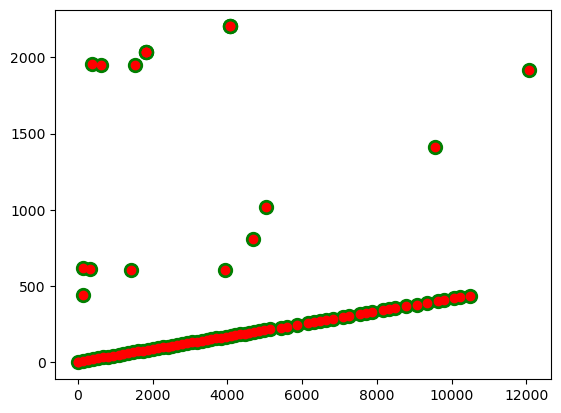

In [14]:
plt.figure()

plt.scatter(np.array(all_xt)[:,0], np.array(all_xt)[:,1], c='green',s=100)
plt.scatter(np.array(all_xhat)[:,0], np.array(all_xhat)[:,1], c='red')